In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple


In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000


In [3]:
data_dir = pathlib.Path('Melody RNN')




In [4]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))


Number of files: 7


In [5]:
sample_file = filenames[1]
print(sample_file)


Melody RNN/dataset/4.mid


In [6]:
pm = pretty_midi.PrettyMIDI(sample_file)


/home/developer/.local/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [7]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)


In [8]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


In [9]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)


Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [10]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')


0: pitch=35, note_name=B1, duration=0.2500
1: pitch=75, note_name=D#5, duration=0.5000
2: pitch=47, note_name=B2, duration=0.2500
3: pitch=35, note_name=B1, duration=0.2500
4: pitch=71, note_name=B4, duration=0.1250
5: pitch=47, note_name=B2, duration=0.2500
6: pitch=75, note_name=D#5, duration=0.1250
7: pitch=37, note_name=C#2, duration=0.2500
8: pitch=49, note_name=C#3, duration=0.2500
9: pitch=77, note_name=F5, duration=0.5000


In [11]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


In [12]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()


,pitch,start,end,step,duration
0,35,0.00,0.250,0.00,0.250
1,75,0.00,0.500,0.00,0.500
2,47,0.25,0.500,0.25,0.250
3,35,0.50,0.750,0.25,0.250
4,71,0.75,0.875,0.25,0.125


In [13]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]


array(['B1', 'D#5', 'B2', 'B1', 'B4', 'B2', 'D#5', 'C#2', 'F5', 'C#3'],
      dtype='<U3')

In [14]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)


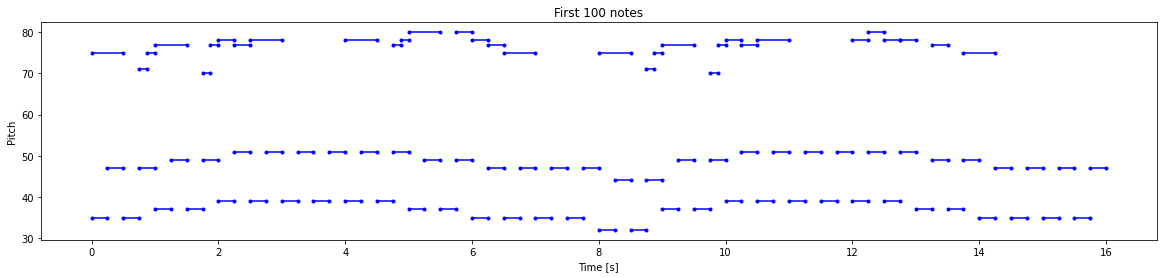

In [15]:
plot_piano_roll(raw_notes, count=100)


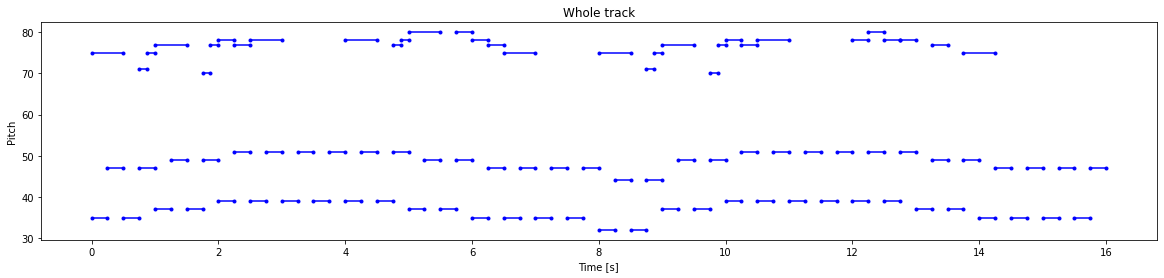

In [16]:
plot_piano_roll(raw_notes)


In [17]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))


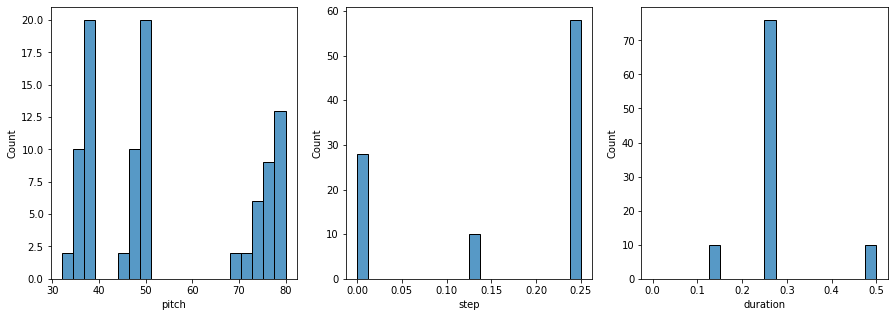

In [18]:
plot_distributions(raw_notes)


In [19]:
num_files = 7
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)


/home/developer/.local/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [20]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)


Number of notes parsed: 510


In [21]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)


In [22]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec


2022-05-23 07:43:23.797210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-23 07:43:23.798658: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-23 07:43:23.799079: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-05-23 07:43:23.827061: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [23]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)


In [24]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec


(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [25]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)


sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.625     0.        0.5      ]
 [0.5859375 0.        0.5      ]
 [0.4375    0.        3.       ]
 [0.4921875 0.5       0.5      ]
 [0.53125   0.5       0.5      ]
 [0.5546875 0.5       0.5      ]
 [0.5859375 0.5       0.5      ]
 [0.625     0.        0.5      ]
 [0.4375    0.5       0.5      ]
 [0.4921875 0.5       0.5      ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=71.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.5>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.5>}


In [26]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))


In [27]:
train_ds.element_spec


(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [28]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)


In [29]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [30]:
losses = model.evaluate(train_ds, return_dict=True)
losses


7/7 [==============================] - 2s 105ms/step - loss: 4.9776 - duration_loss: 0.0899 - pitch_loss: 4.8478 - step_loss: 0.0399


{'loss': 4.977645397186279,
 'duration_loss': 0.08989670127630234,
 'pitch_loss': 4.847838878631592,
 'step_loss': 0.03990958258509636}

In [31]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)


In [32]:
model.evaluate(train_ds, return_dict=True)


7/7 [==============================] - 1s 36ms/step - loss: 0.3722 - duration_loss: 0.0899 - pitch_loss: 4.8478 - step_loss: 0.0399


{'loss': 0.3721982538700104,
 'duration_loss': 0.08989670127630234,
 'pitch_loss': 4.847838878631592,
 'step_loss': 0.03990958258509636}

In [33]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]


In [34]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/50
7/7 [==============================] - 3s 66ms/step - loss: 0.3181 - duration_loss: 0.0476 - pitch_loss: 4.7881 - step_loss: 0.0311
Epoch 2/50
7/7 [==============================] - 0s 50ms/step - loss: 0.2933 - duration_loss: 0.0370 - pitch_loss: 4.6638 - step_loss: 0.0231
Epoch 3/50
7/7 [==============================] - 0s 55ms/step - loss: 0.2865 - duration_loss: 0.0374 - pitch_loss: 4.5467 - step_loss: 0.0218
Epoch 4/50
7/7 [==============================] - 0s 55ms/step - loss: 0.2752 - duration_loss: 0.0371 - pitch_loss: 4.3367 - step_loss: 0.0212
Epoch 5/50
7/7 [==============================] - 0s 44ms/step - loss: 0.2583 - duration_loss: 0.0423 - pitch_loss: 3.8822 - step_loss: 0.0218
Epoch 6/50
7/7 [==============================] - 0s 49ms/step - loss: 0.2821 - duration_loss: 0.0731 - pitch_loss: 3.7490 - step_loss: 0.0215
Epoch 7/50
7/7 [==============================] - 0s 47ms/step - loss: 0.2584 - duration_loss: 0.0464 - pitch_loss: 3.8075 - step_loss: 0.0216

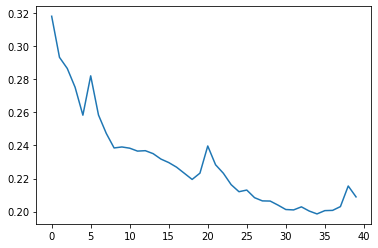

In [35]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()


In [36]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)


In [37]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))


In [38]:
generated_notes.head(10)


,pitch,step,duration,start,end
0,47,0.155417,0.286661,0.155417,0.442078
1,37,0.368124,0.810115,0.523541,1.333655
2,73,0.903750,0.915556,1.427290,2.342846
3,32,1.068070,1.019883,2.495361,3.515244
4,73,1.209512,1.040050,3.704873,4.744923
5,71,1.200475,1.085240,4.905348,5.990588
6,54,1.234586,1.079094,6.139934,7.219028
7,75,1.266323,1.087442,7.406257,8.493699
8,80,1.242957,1.078830,8.649214,9.728044
9,76,1.252236,1.054863,9.901450,10.956313


In [40]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm


In [45]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)


fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


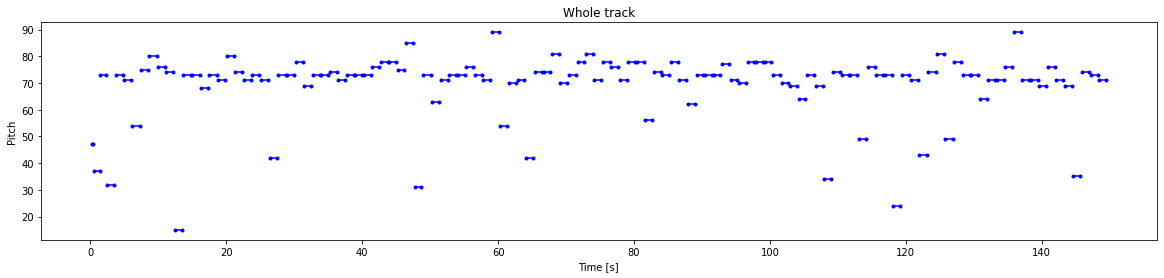

In [47]:
plot_piano_roll(generated_notes)


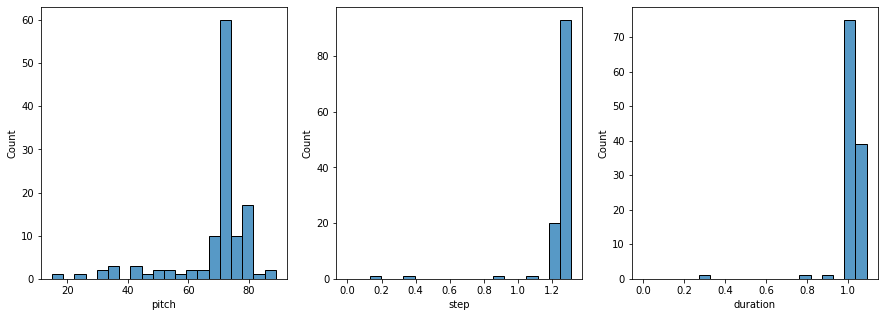

In [48]:
plot_distributions(generated_notes)
